In [ ]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Three qubits to use as graph nodes, one as coin.
node_count = 3
dev = qml.device("default.qubit", wires=node_count+1)

In [ ]:
# LSB is on the left (Big endian)
def walk_step(node_count):
    # Flip the coin
    qml.Hadamard(wires=node_count)

    # Implement the Addition Operator

    qml.PauliX(wires=node_count)

    for i in range(node_count, 0, -1):
        controls = [v for v in range(node_count, i - 1, -1)]
        qml.MultiControlledX(control_wires=controls, wires=i - 1)
        if i > 1:
            qml.PauliX(wires=i - 1)

    qml.PauliX(wires=node_count)

    # We should X all the qubits here but the same should happen in the subtraction step so they cancel out

    # Implement the Substraction Operator
    for i in range(1, node_count + 1):
        controls = [v for v in range(node_count, i - 1, -1)]
        qml.MultiControlledX(control_wires=controls, wires=i - 1)
        if i < node_count:
            qml.PauliX(wires=i)


@qml.qnode(dev)
def circuit(params):
    node_count = 3
    qml.PauliX(wires=0)
    qml.PauliX(wires=node_count)

    for _ in range(params[0]):
        walk_step(node_count)

    return [qml.sample(qml.PauliZ(i)) for i in range(node_count)]
    # return [qml.expval(qml.PauliZ(i)) for i in range(node_count)]


In [ ]:
def refined_results(x):
    result = circuit(x, shots=1000)
    result[result==-1] = 0
    for i in range(result.shape[1]):
        pass
        
    return result.sum(axis=1)


In [119]:

def another_refined_results(x):
    dict_result = {i: 0 for i in range(2 ** node_count)}
    result = circuit(x, shots=1000)
    result[result==-1] = 0
    for i in range(result.shape[1]):
        int_result = sum([j * 2**n for j, n in enumerate(result[:, i][::-1])])
        dict_result[int(int_result)] += 1
    
    return dict_result
        

In [ ]:
def cost_result(result):
    return result[0]

In [ ]:
# Bias against the first qubit being 1.
def cost_fn(x):
    result = refined_results(x)
    return result[0]

In [ ]:
init_params = np.array([4, 0])
result = refined_results(init_params)
print(result)
result[:, 0][::-1]


In [120]:
init_params = np.array([4, 0])
result = another_refined_results(init_params)
print(result)

{0: 0, 1: 0, 2: 0, 3: 107, 4: 137, 5: 632, 6: 124, 7: 0}


In [ ]:
result[:, 1][::-1]
result.shape
for i, j in enumerate(result[:, 1][::-1]):
    print(i, j)

In [ ]:
# set the number of steps
steps = 100
# set the initial parameter values
min_step, min_cost, min_result = -1, 1e9, None

for i in range(1, steps):
    # update the circuit parameters
    params = np.array([i, 0])
    
    result = refined_results(params)
    # calculate the cost
    cost = cost_result(result)

    if cost < min_cost:
        min_cost = cost
        min_step = i
        min_result = result

    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost))

print("Optimized walk steps: {}".format(min_step))

{0: 0, 1: 0, 2: 0, 3: 0, 4: 1000, 5: 0, 6: 0, 7: 0}


<BarContainer object of 8 artists>

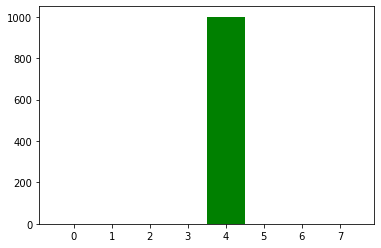

In [122]:
result = another_refined_results(np.array([0, min_step]))
print(result)
plt.bar(result.keys(), result.values(), 1.0, color='g')
